## <font color='red'>Comparing all models</font> 


### Preprocessing data splitting a test train common to all models: test_size = 0.1,  min_like=5, repeat=5, K=5 over filtered data

In [1]:
from TFM_Granatiero_Utils.TFM_Pre_Process import *
from TFM_Granatiero_Utils.TFM_Base_Models import *


In [3]:
data_full = pd.read_csv('../TFM_Granatiero_Data/week_01mar_30abr.csv', index_col=0)
restaurants_df = pd.read_csv('../TFM_Granatiero_Data/restaurants_Datos_Init_01_05_2021.csv', index_col=0)
score_data_bin = pd.read_csv('../TFM_Granatiero_Data/score_bin.csv', index_col=0)
data_full.shape, score_data_bin.shape

((458641, 9), (27930, 3))

In [3]:
Score_Rules=[]
pre = PreProcessing_Data(data_full, restaurants_df, Score_Rules)
pre.init_simple_data()
pre.clean_anomalies(10, 1000)
pre.filter_data_for_collaborative()
pre.fit_data_score_bin()
pre.fit_User_Items_bin(5,5)
filtered_data = pre.simple_data
UI = pre.User_Items_bin

In [7]:
from sklearn.model_selection import train_test_split
import random

random.seed(3)
ts_size=0.1
train_bin, test_bin = train_test_split(pre.score_data_bin, test_size=ts_size)

### RANDOM MODEL

In [8]:
random_score = random_scores_bin(train_bin, repeat=5, K=5, min_rated_restaurants=5, min_rated_users=5, ts_size=0.1)
mean_acc_random, mean_f1_random, mean_precision_random, mean_recall_random, User_Tested_Ratio_random = random_score[0]
sigma_random = random_score[1]

In [9]:
random_score

([0.01487219349706998,
  0.018175843479813082,
  0.015471916495642396,
  0.03112456845262455,
  0.6758409283824143],
 0.001610323210674671)

### MOST POPULAR MODEL

In [10]:
pop_score = pop_scores_bin(train_bin, repeat=5, K=5, min_rated_restaurants=5, min_rated_users=5, ts_size=0.1)
mean_acc_pop, mean_f1_pop, mean_precision_pop, mean_recall_pop, User_Tested_Ratio_pop = pop_score[0]
sigma_pop = pop_score[1]


In [11]:
pop_score

([0.08205860996738645,
  0.0860570873947504,
  0.07041142514383844,
  0.14716430541349007,
  0.6805157963081874],
 0.009208508646902489)

In [12]:
total_pop_rest = pop_counter(UI, K=5)


In [13]:
total_recommended = len(set([i[0] for i in total_pop_rest]))
'Most pop is recommending {} restaurants'.format(total_recommended)

'Most pop is recommending 20 restaurants'

### CONTENT BASED MODEL: with rates and dropping "food-types" feature

In [4]:
from TFM_Granatiero_Utils.TFM_Content_Based import *

In [5]:
def open_app_datas(dir_path):
    
    def save_Datos(name, dir_path):
        file_path = dir_path + '/' + name + '.csv' 
        return pd.read_csv(file_path)

    list_of_df = []
    for filename_csv in os.listdir(dir_path):
        if filename_csv.endswith(".csv"):
            filename = os.path.splitext(filename_csv)[0]
            globals()[filename] = save_Datos(filename, dir_path)
            list_of_df.append(filename)
    
    return list_of_df 

            

In [6]:
list_data_init = open_app_datas('../TFM_Granatiero_Data/Datos_Init_01_05_2021')
list_data_init

['homes__first_action_neighborhoods',
 'reservations',
 'strapi_permission',
 'homes__second_action_food_types',
 'homes__second_action_neighborhoods',
 'homes',
 'profiles__vibes',
 'push_tokens',
 'components_restaurants_promoteds',
 'vibe',
 'neighborhoods',
 'profiles',
 'homes__first_action_food_types',
 'restaurants_components',
 'homecards__vibes',
 'foodtypes',
 'users-permissions_permission',
 'homecards',
 'profiles__food_types',
 'strapi_webhooks',
 'profiles__favorites',
 'profiles__push_tokens',
 'app_homes__home_cards',
 'homes__second_action_vibes',
 'homecards__food_types',
 'strapi_users_roles',
 'strapi_role',
 'homecards__neighborhoods',
 'core_store',
 'cities',
 'permissions_role',
 'vibes',
 'permissions_user',
 'homecards__localizations',
 'promos',
 'components_restaurants_promoteds__vibes',
 'locales',
 'components_restaurants_promoteds__food_types',
 'promos__vibes',
 'components_restaurants_information',
 'promos__food_types',
 'app_homes',
 'homes__first_act

In [7]:
def score_content_scored(score_bin,  restaurants_Datos_Init, \
                         restaurants__food_types_Datos_Init, restaurants__vibes_Datos_Init,\
                         foodtypes_Datos_Init, vibes_Datos_Init, \
                         neighborhoods_Datos_Init, filtered_data, col_to_drop, repeat, K=5, ts_size=0.1):
    
    tot_scores=[]
    for i in range(repeat):     
    
        test = train_test_split(score_bin.set_index(['user_id','restaurant_id']), test_size=ts_size)[1]
        test_idx = test.index
    
        idx_to_drop = filtered_data[filtered_data.is_positive==True].reset_index().set_index(['user_id',\
                                                    'restaurant_id']).loc[test_idx,:].set_index('index').index
    
        train_filtered = filtered_data.drop(index=idx_to_drop)
        pre = PreProcessing_Data(data_full, restaurants_df, Rules)
        pre.simple_data = train_filtered
    
        pre.fit_data_score()
        pre.fit_User_Items_Matrix(5,5)
    
        rec = Content_Based_Recc(data_full,  pre.User_Items.fillna(0), restaurants_Datos_Init, \
                      restaurants__food_types_Datos_Init, restaurants__vibes_Datos_Init,\
                      foodtypes_Datos_Init, vibes_Datos_Init, neighborhoods_Datos_Init)
    
        rec.fit_Items_Content_df()
        rec.fit_User_Content_df()

        tot_scores. append(mean_prec_recall_at_k_content(pre.User_Items.fillna(0), test.reset_index(),\
                           rec.predict_K_ranked, rec.dict_id_off2unoff, K, col_to_drop, binary=False))
        
            
    mean_scores = [sum(y) / len(y) for y in zip(*tot_scores)]
    sigma_acc = np.sqrt(sum([(i[0]-mean_scores[0])**2 for i in tot_scores])/5)
    
    return mean_scores, sigma_acc




In [8]:
type_cols = ['food-type_id 1', 'food-type_id 2', 'food-type_id 3', 'food-type_id 4',
            'food-type_id 5', 'food-type_id 6', 'food-type_id 7', 'food-type_id 8',
            'food-type_id 9', 'food-type_id 10', 'food-type_id 11',
            'food-type_id 12', 'food-type_id 13', 'food-type_id 14',
            'food-type_id 15', 'food-type_id 16', 'food-type_id 17',
            'food-type_id 18', 'food-type_id 19', 'food-type_id 20',
            'food-type_id 21', 'food-type_id 23', 'food-type_id 24',
            'food-type_id 25']

In [ ]:
scored_score_no_type =   score_content_scored(train_bin, restaurants, \
                         restaurants__food_types, restaurants__vibes,\
                         foodtypes, vibes, neighborhoods, filtered_data, col_to_drop=type_cols,\
                         repeat=5, K=5, ts_size=0.1)


In [49]:
scored_score_no_type 

([0.08000502296745943,
  0.07905393084443321,
  0.06531524850925799,
  0.13864164581908137,
  0.6909908095228686],
 0.004604507407988403)

## Collaborative Model: test_size = 0.1, min_like=5, N_neigh=10

In [12]:
from TFM_Granatiero_Utils.TFM_Collaborative import *

In [11]:
simple_data = pd.read_csv('../TFM_Granatiero_Data/simple_data_filtered_cleaned.csv', index_col=0)

In [14]:
scores_bin_coll = scores_bin(score_data_bin,repeat=5,N_neigh=10,K=5,min_rated_restaurants=5,min_rated_users=5)

In [15]:
scores_bin_coll

([0.12660733447317982,
  0.13673704480817123,
  0.11655671318337042,
  0.22553631498247734,
  0.6837195660462092],
 0.0071656613890225505)

In [ ]:
rec_bin = CollaborativeFiltering(pre.User_Items_bin, cosine_similarity)
rec_bin.fit_items_bin()

In [17]:
def coll_counter(UI, K, N_neigh, predict):
    '''It counts all the different restaurants suggested for all the users for collab'''
    total_rest = []
    for u in UI.index:
        total_rest.append(predict(u, K, N_neigh).index)
    
    return total_rest

In [27]:
coll_rest = coll_counter(pre.User_Items_bin, 5, 10, rec_bin.predict_K_item_bin)

In [28]:
total_recommended_coll = len(set([i[0] for i in coll_rest]))
'Most pop is recommending {} restaurants'.format(total_recommended_coll)

'Most pop is recommending 166 restaurants'

### Plotting results

In [66]:
Results_df = pd.DataFrame(columns=['model', 'accuracy', 'f1' , 'p@5', 'r@5', 'sigma_acc'])
Results_df['model']=['Random', 'Most Pop', 'Content Based', 'Collaborative Bin']
Results_df['accuracy']=[random_score[0][0], pop_score[0][0], scored_score_no_type[0][0], scores_bin_coll[0][0]]
Results_df['f1']=[random_score[0][1], pop_score[0][1], scored_score_no_type[0][1], scores_bin_coll[0][1]]
Results_df['p@5']=[random_score[0][2], pop_score[0][2], scored_score_no_type[0][2], scores_bin_coll[0][2]]
Results_df['r@5']=[random_score[0][3], pop_score[0][3], scored_score_no_type[0][3], scores_bin_coll[0][3]]
Results_df['sigma_acc']=[random_score[1], pop_score[1], scored_score_no_type[1], scores_bin_coll[1]]



In [23]:
Results_df = pd.read_csv('All_Models_metrics.csv', index_col=0)
Results_df

,model,accuracy,f1,p@5,r@5,sigma_acc
0,Random,0.014976,0.018997,0.016159,0.031632,0.002089
1,Most Pop,0.098884,0.097291,0.082661,0.161096,0.007132
2,Content Based,0.080005,0.079054,0.065315,0.138642,0.004605
3,Collaborative,0.127453,0.138785,0.117733,0.227204,0.004642


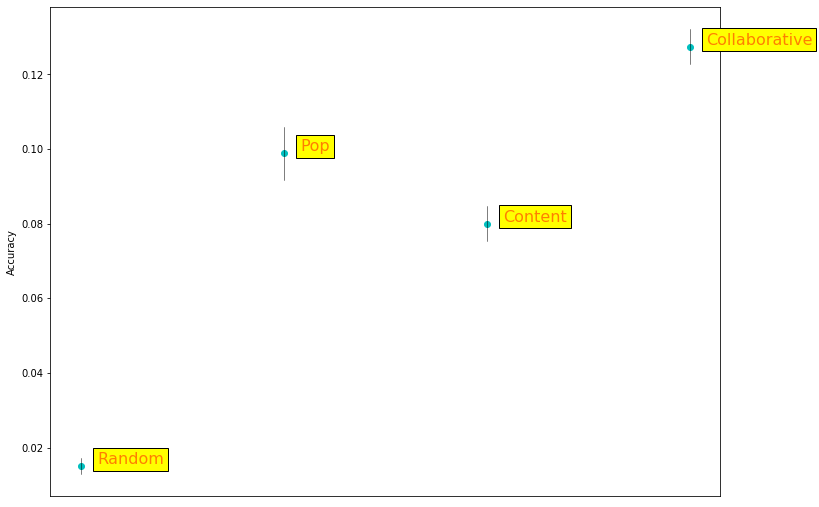

In [27]:
means_w = [Results_df.loc[0,'accuracy'], Results_df.loc[1,'accuracy'],\
           Results_df.loc[2,'accuracy'], Results_df.loc[3,'accuracy']]
weeks = [0 ,5 ,10 ,15]

plt.figure(figsize=(12,9))
plt.plot(weeks, means_w, 'o', color='c')

plt.text(x=weeks[0]+0.4, y=means_w[0]+.0006, s='Random',\
        fontdict=dict(color='red', alpha=0.5, size=16), bbox=dict(facecolor='yellow',alpha=1))
plt.text(x=weeks[1]+0.4, y=means_w[1]+.0006, s='Pop',\
        fontdict=dict(color='red', alpha=0.5, size=16), bbox=dict(facecolor='yellow',alpha=1))
plt.text(x=weeks[2]+0.4, y=means_w[2]+.0006, s='Content',\
        fontdict=dict(color='red', alpha=0.5, size=16), bbox=dict(facecolor='yellow',alpha=1))
plt.text(x=weeks[3]+0.4, y=means_w[3]+.0006, s='Collaborative',\
        fontdict=dict(color='red', alpha=0.5, size=16), bbox=dict(facecolor='yellow',alpha=1))

plt.plot([0,0], [means_w[0]-Results_df.loc[0,'sigma_acc'], means_w[0]+Results_df.loc[0,'sigma_acc']], 'k-', lw=.5)
plt.plot([5,5], [means_w[1]-Results_df.loc[1,'sigma_acc'], means_w[1]+Results_df.loc[1,'sigma_acc']], 'k-', lw=.5)
plt.plot([10,10], [means_w[2]-Results_df.loc[2,'sigma_acc'], means_w[2]+Results_df.loc[2,'sigma_acc']], 'k-', lw=.5)
plt.plot([15,15], [means_w[3]-Results_df.loc[3,'sigma_acc'], means_w[3]+Results_df.loc[3,'sigma_acc']], 'k-', lw=.5)

plt.ylabel('Accuracy')
plt.xticks([])

#plt.savefig('TFM_figures/All_models_accuracy.jpg', dpi=300, bbox_inches="tight")